In [6]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
from semeval_data_helper import load_semeval_data
# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams['figure.figsize'] = (16,9)

In [2]:
reload(dh)
DH = dh.DataHandler('data/shuffled_wiki_sdp_50000', valid_percent=1)

Creating Data objects...
Done creating Data objects
549566 total examples :: 544070 training : 5496 valid (99:1 split)
Vocab size: 22265 Dep size: 46


In [3]:
# print(DH.max_seq_len)
# paths, targets = DH.readable_data(show_dep=True)
# for p, t in zip(paths, targets) :
#     t = t.split(", ")
#     print("%s (%s) %s" % (t[0], p, t[1]))

In [4]:
%time
# load the pretrained word embeddings
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [7]:
train, valid, test, label2int, int2label = load_semeval_data()

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 10)
Num training: 7108
Num valididation: 891
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer

In [ ]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

In [15]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))

18498 / 22265 pretrained


In [16]:
config = {
    'max_num_steps':DH.max_seq_len,
    'word_embed_size':300,
    'dep_embed_size':25,
    'vocab_size':DH.vocab_size,
    'dep_vocab_size':DH.dep_size,
    'pretrained_word_embeddings':word_embeddings,
    'max_grad_norm':3.,
    'model_name':'drnn_wiki_semeval_w2v',
    'checkpoint_prefix':'checkpoints/',
    'summary_prefix':'tensor_summaries/'
}
try:
    tf.reset_default_graph()
except:
    pass
try:
    tf.get_default_session().close()
except:
    pass
drnn = RNN_Embed(config)
print(drnn)

<DPNN: W:300, D:25, H:600, V:22265>


In [33]:
def run_validation_test(num_nearby=20):
    valid_phrases, valid_targets , _, valid_lens = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index]
    padded_qp = np.zeros([DH.max_seq_len, 2]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]    
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, valid_phrases, valid_lens)
    print("="*80)
    print("Top %i closest phrases to <%s> '%s' <%s>" 
          % (num_nearby, DH.vocab_at(query_target[0]), 
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[1])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f : <%s> '%s' <%s>" 
              % (i, dist, DH.vocab_at(target[0]),
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[1])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [34]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

In [37]:
# hyperparameters
num_epochs = 1
batch_size =50
neg_per = 20
num_nearby = 50
nearby_mod = 50
sample_power = .75
DH.scale_vocab_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

for epoch in range(num_epochs):
    offset = 0 if epoch else 400
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, offset=offset, neg_per=neg_per)):
        if not step: step = offset
        t0 = time()
        loss = drnn.partial_fit(*batch)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
            ml,sl = divmod(left, 60)
            hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                  % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_loss = drnn.validation_loss(*DH.validation_batch())
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()

(0:0:4) step 400/10881, epoch 0 Training Loss = 0.22316 :: 1203.966 phrases/sec :: (2:38:4) hours left
Top 50 closest phrases to <regions> 'of consisting from france ireland' <portugal>
0: 1.000 : <regions> 'of consisting from france ireland' <portugal>
1: 0.988 : <criticism> 'of style in thus is' <hierarchy>
2: 0.988 : <brotherhood> 'of column is friday is' <procession>
3: 0.988 : <scotland> 'of galleries by managed grants' <offices>
4: 0.988 : <century> 'of end by consisted escaped' <slaves>
5: 0.988 : <schools> 'of one as selected as' <part>
6: 0.988 : <people> 'of protector as known from' <snake>
7: 0.987 : <bridge> 'of members constructed using from' <1800s>
8: 0.987 : <richmond> 'of church by supported was' <he>
9: 0.987 : <series> 'of collection features prominently in' <ending>
10: 0.987 : <announcement> 'of as secured through activities' <partnerships>
11: 0.987 : <board> 'of president as shek in' <taiwan>
12: 0.987 : <valley> 'of side on situated is' <metres>
13: 0.986 : <lan

In [334]:
drnn.checkpoint()

In [43]:
# test the embeddings

### VALID ###
# valid_phrases, valid_targets, _, valid_lens = DH.validation_batch()
# phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(valid_phrases, valid_targets, valid_lens)
# phrase_labels, target_labels = DH.readable_data(valid=True)

### TRAIN ###
train_phrases, train_targets, _, train_lens = DH.batches(500, neg_per=0, offset=0).next()
phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(train_phrases, train_targets, train_lens)
phrase_labels, target_labels = DH.readable_data(show_dep=True, valid=False)
        
# phrase_embeds /= np.sqrt(np.sum(phrase_embeds**2, 1, keepdims=True))
# target_embeds /= np.sqrt(np.sum(target_embeds**2, 1, keepdims=True))

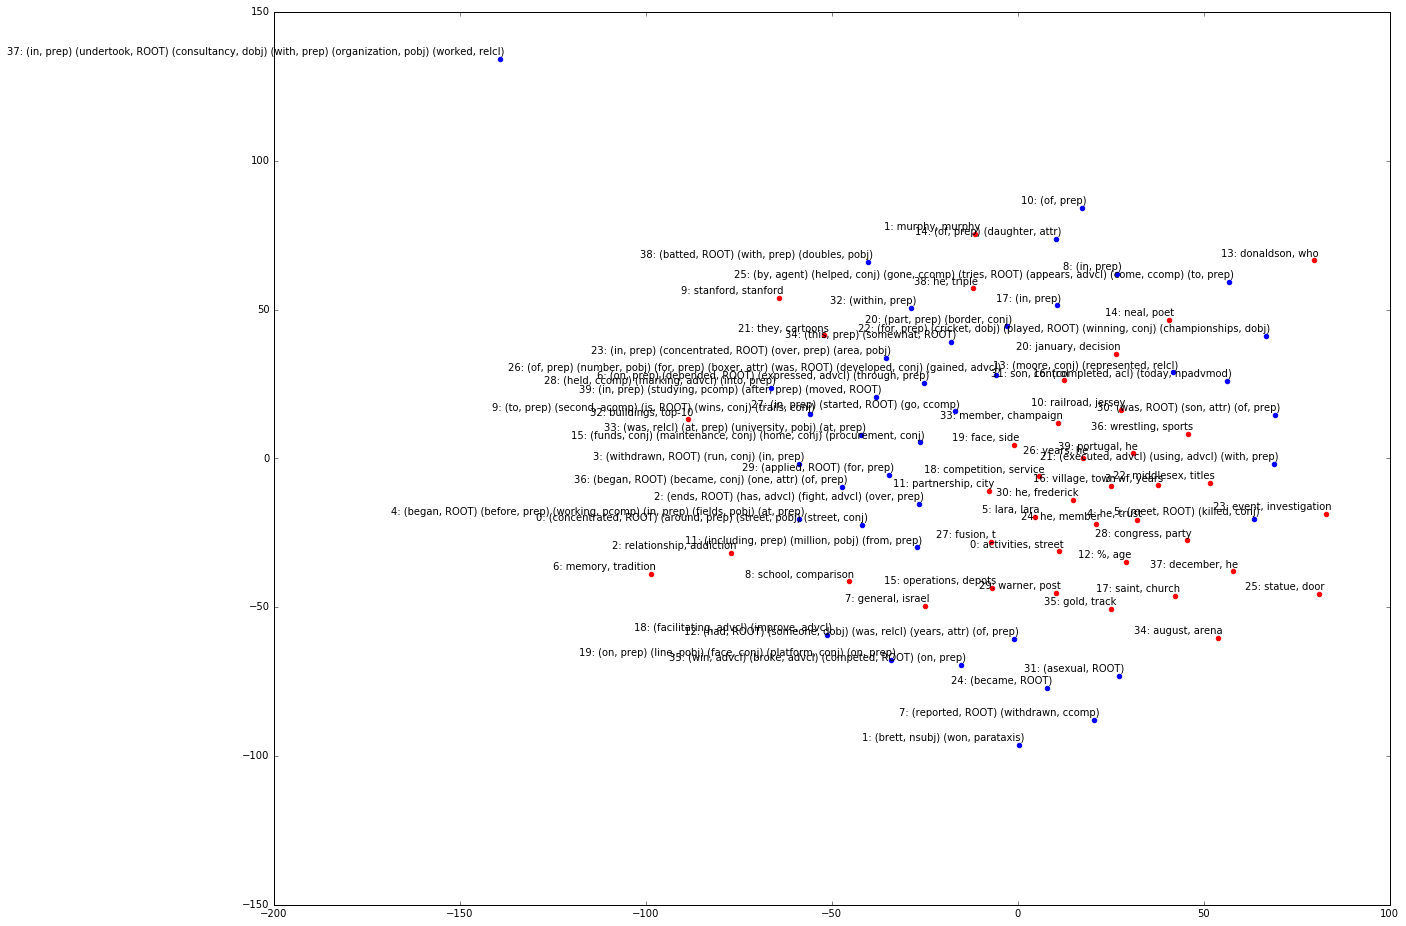

In [46]:
### JOINT ###
start = 0
stride = 40
end = start + stride

lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
# lowd = PCA(n_components=2)

joint_embeds = np.vstack([phrase_embeds[start:end], target_embeds[start:end]])
joint_2d = lowd.fit_transform(joint_embeds)
phrase_2d, target_2d = joint_2d[:stride], joint_2d[stride:]

fig, ax = plt.subplots(figsize=(20,16))
for i, label in enumerate(phrase_labels[start:end]):
    label = "%i: %s" % (i, label)
    x, y = phrase_2d[i,:]
    ax.scatter(x, y, color='b')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
for i, label in enumerate(target_labels[start:end]):
    label = "%i: %s" % (i, label)
    x, y = target_2d[i,:]
    ax.scatter(x, y, color='r')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

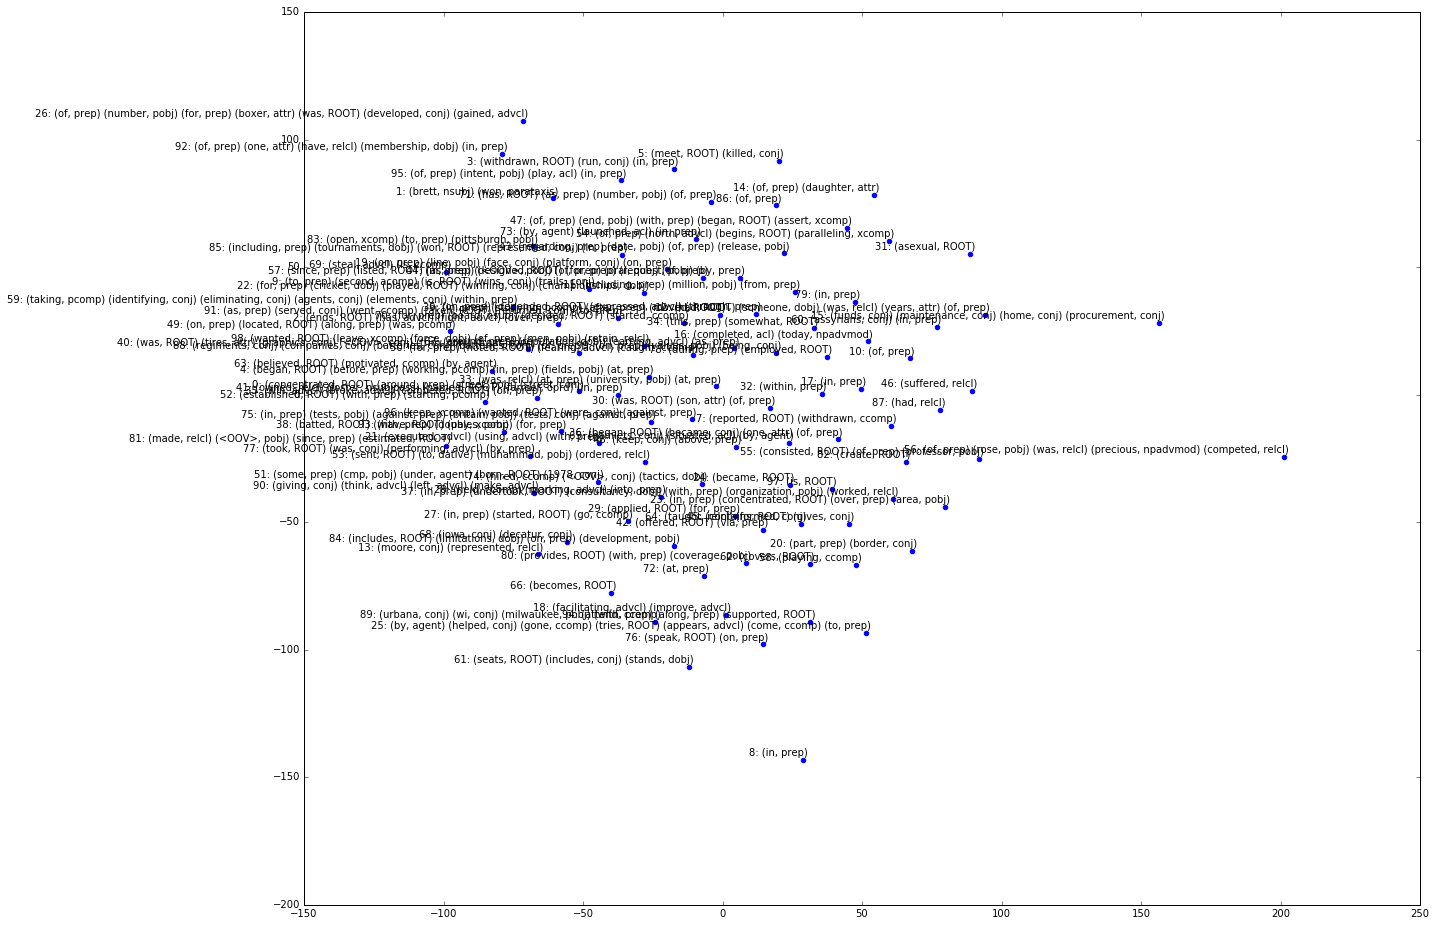

In [47]:
### PHRASE ONLY ###
start = 0
stride = 100
end = start + stride

lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
# lowd = PCA(n_components=2)

phrase_2d = lowd.fit_transform(phrase_embeds[start:end])

fig, ax = plt.subplots(figsize=(20,16))
for i, label in enumerate(phrase_labels[start:end]):
    label = "%i: %s" % (i, label)
    x, y = phrase_2d[i,:]
    ax.scatter(x, y, color='b')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

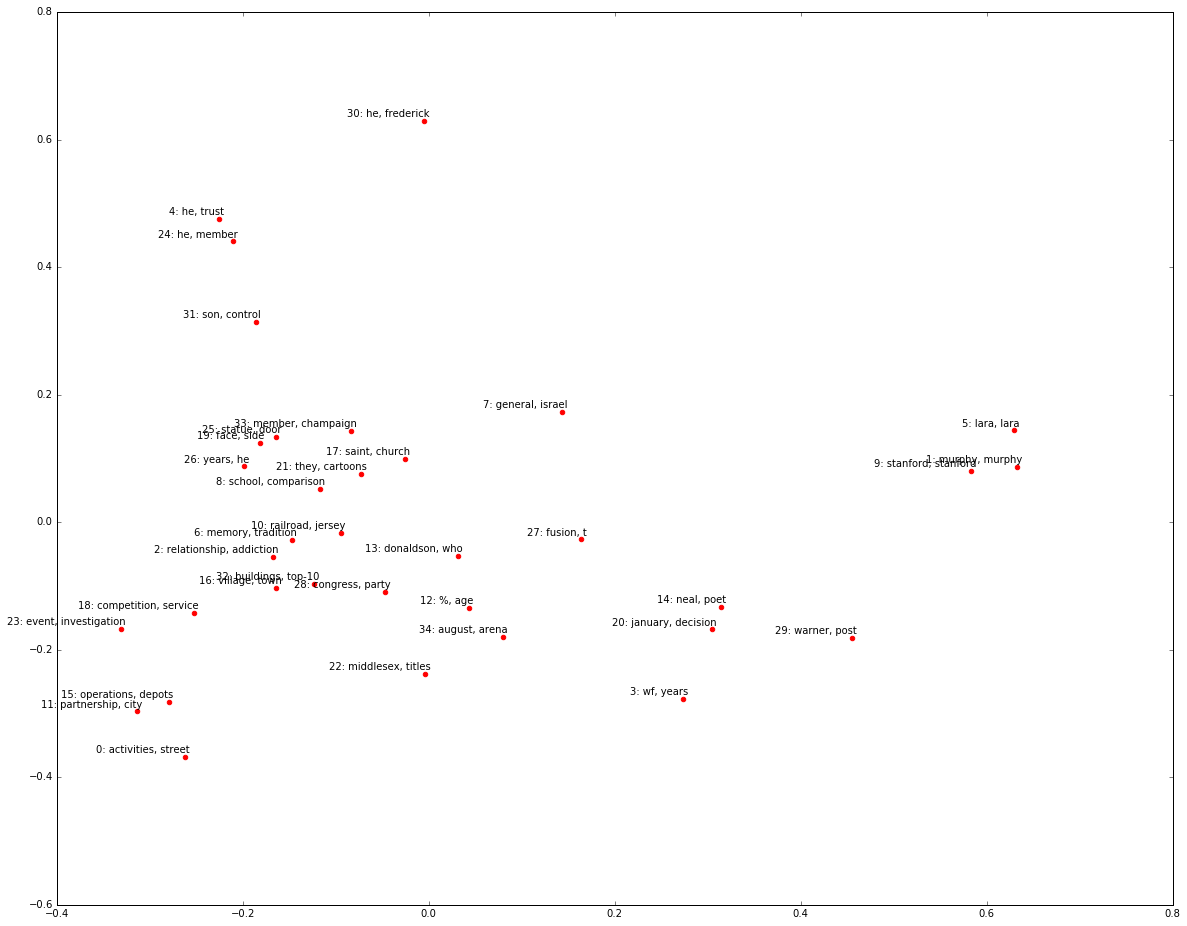

In [41]:
### TARGET ONLY ###
start = 0
stride = 35
end = start + stride

# lowd = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000)
lowd = PCA(n_components=2)

target_2d = lowd.fit_transform(target_embeds[start:end])

fig, ax = plt.subplots(figsize=(20,16))
for i, label in enumerate(target_labels[start:end]):
    label = "%i: %s" % (i, label)
    x, y = target_2d[i,:]
    ax.scatter(x, y, color='r')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

# Test out semeval data

In [49]:
from semeval_data_helper import load_semeval_data

In [50]:
se_train, se_valid, se_test, se_label2int, se_int2label = load_semeval_data()

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 10)
Num training: 7108
Num valididation: 891
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer

# Define the Relation Extraction model
It is the same as RNN_embed, but we also construct a classification graph on top

This allows us to train unsupervised, and then train supervised after.

In [51]:
class RelEmbed(object):
    """ Encapsulation of the dependency RNN lang model
    
    Largely inspired by https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/ptb_word_lm.py
    """
    def __init__(self, config):
#         self.batch_size = config['batch_size']
        self.max_num_steps = config['max_num_steps']
        self.word_embed_size = config['word_embed_size']
        self.dep_embed_size = config['dep_embed_size']
        self.input_size = self.word_embed_size + self.dep_embed_size
        self.hidden_size = 2 * self.word_embed_size #config['hidden_size']
        self.pretrained_word_embeddings = config['pretrained_word_embeddings'] # None if we don't provide them
        if np.any(self.pretrained_word_embeddings):
            assert self.word_embed_size == self.pretrained_word_embeddings.shape[1]
        self.num_classes = config['num_predict_classes']
        self.max_grad_norm = config['max_grad_norm']
        
        self.vocab_size = config['vocab_size']
        self.dep_vocab_size = config['dep_vocab_size']
        self.name = config['model_name']
        self.checkpoint_prefix = config['checkpoint_prefix'] + self.name
        self.summary_prefix = config['summary_prefix'] + self.name
        
        self.initializer = tf.random_uniform_initializer(-1., 1.)
        with tf.name_scope(self.name):
            with tf.name_scope("Forward"):
                self._build_forward_graph()
                self._build_classification_graph()
            with tf.name_scope("Backward"):
                self._build_train_graph()
                self._build_class_train_graph()
            with tf.name_scope("Nearby"):
                self._build_similarity_graph()
        
        self._valid_accuracy = tf.Variable(0.0, trainable=False)
        self._valid_acc_summary = tf.merge_summary([tf.scalar_summary("Valid_accuracy", self._valid_accuracy)])

        self.saver = tf.train.Saver(tf.all_variables())
            
        self.session = tf.InteractiveSession()
        self.session.run(tf.initialize_all_variables())        
        self.summary_writer = tf.train.SummaryWriter(self.summary_prefix, self.session.graph_def)
        
    def save_validation_accuracy(self, new_score):
        assign_op = self._valid_accuracy.assign(new_score)
        _, summary = self.session.run([assign_op, self._valid_acc_summary])
        self.summary_writer.add_summary(summary)
        
    def _build_forward_graph(self):
        # input tensor of zero padded indices to get to max_num_steps
        # None allows for variable batch sizes
        with tf.name_scope("Inputs"):
            self._input_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 2]) # [batch_size, w_{1:N}, 2]
            self._input_targets = tf.placeholder(tf.int32, [None, 2]) # [batch_size, w_x]
            self._input_labels = tf.placeholder(tf.int32, [None, 1]) # [batch_size, from true data?] \in {0,1}
            self._input_lengths = tf.placeholder(tf.int32, [None, 1]) # [batch_size, N] (len of each sequence)
            batch_size = tf.shape(self._input_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            if np.any(self.pretrained_word_embeddings):
                self._word_embeddings = tf.Variable(self.pretrained_word_embeddings,name="word_embeddings")
                self._left_target_embeddings = tf.Variable(self.pretrained_word_embeddings, name="left_target_embeddings")
                self._right_target_embeddings = tf.Variable(self.pretrained_word_embeddings, name="right_target_embeddings")
            else:
                self._word_embeddings = tf.get_variable("word_embeddings", 
                                                        [self.vocab_size, self.word_embed_size],
                                                        dtype=tf.float32)
                self._left_target_embeddings = tf.get_variable("left_target_embeddings", 
                                                        [self.vocab_size, self.word_embed_size],
                                                        dtype=tf.float32)
                self._right_target_embeddings = tf.get_variable("right_target_embeddings", 
                                                        [self.vocab_size, self.word_embed_size],
                                                        dtype=tf.float32)
            
            self._dependency_embeddings = tf.get_variable("dependency_embeddings", 
                                                    [self.dep_vocab_size, self.dep_embed_size],
                                                    dtype=tf.float32)
            # TODO: Add POS embeddings
            
            input_embeds = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._input_phrases, [0,0,0], [-1, -1, 1]))
            dep_embeds = tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._input_phrases, [0,0,1], [-1, -1, 1]))
            left_target_embeds = tf.nn.embedding_lookup(self._left_target_embeddings, 
                                                        tf.slice(self._input_targets, [0,0], [-1, 1]))
            right_target_embeds = tf.nn.embedding_lookup(self._right_target_embeddings, 
                                                        tf.slice(self._input_targets, [0,1], [-1, 1]))
#             print(tf.slice(self._input_phrases, [0,0,1], [-1, -1, 1]).get_shape(), dep_embeds.get_shape())
#             print(left_target_embeds.get_shape(), right_target_embeds.get_shape())
            self._target_embeds = tf.squeeze(tf.concat(2, [left_target_embeds, right_target_embeds]), [1])
#             print(target_embeds.get_shape())
            # TODO: Add dropout to embeddings
        
        with tf.name_scope("RNN"):
            # start off with a basic configuration
            self.cell = tf.nn.rnn_cell.GRUCell(self.hidden_size, 
                                                input_size=self.input_size)
            # TODO: Add Dropout wrapper
            # TODO: Make it multilevel
#             self._initial_state = self.cell.zero_state(batch_size, tf.float32)
#             print(self._initial_state.get_shape())
            input_words = [ tf.squeeze(input_, [1, 2]) for input_ in tf.split(1, self.max_num_steps, input_embeds)]
            input_deps = [ tf.squeeze(input_, [1, 2]) for input_ in tf.split(1, self.max_num_steps, dep_embeds)]
            inputs = [ tf.concat(1, [input_word, input_dep]) 
                      for (input_word, input_dep) in zip(input_words, input_deps)]

            _, state = tf.nn.rnn(self.cell, inputs, 
                                 sequence_length=tf.squeeze(self._input_lengths, [1]),
                                 dtype=tf.float32)
#                                  initial_state=self._initial_state)
            self._final_state = state
            
        with tf.name_scope("Loss"):
            flat_states = tf.reshape(state, [-1])
            flat_target_embeds = tf.reshape(self._target_embeds, [-1])
#             assert self.hidden_size == (self.word_embed_size), "Hidden state must equal concated inputs" 
            flat_logits = tf.mul(flat_states, flat_target_embeds)
            logits = tf.reduce_sum(tf.reshape(flat_logits, tf.pack([batch_size, -1])), 1)
            self._loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, 
                                                                    tf.to_float(self._input_labels)),
                                        name="neg_sample_loss")
            
        with tf.name_scope("Summaries"):
            
            self._train_cost_summary = tf.merge_summary([tf.scalar_summary("Train_NEG_Loss", self._loss)])
            self._valid_cost_summary = tf.merge_summary([tf.scalar_summary("Validation_NEG_Loss", self._loss)])
        
    def _build_classification_graph(self):
        with tf.name_scope("Classifier"):
            self._softmax_input = tf.concat(1, [self._final_state, self._target_embeds], name="concat_input")
            self._softmax_w = tf.get_variable("softmax_w", [self.softmax_input.get_shape()[1], self.num_classes])
            self._softmax_b = tf.Variable(tf.zeros(tf.float32, [self.num_classes]), name="softmax_b")

            class_logits = tf.matmul(self._softmax_input, self._softmax_w) + self._softmax_b
            self._predictions = tf.argmax(class_logits, 1, name="predict")
            self._predict_probs = tf.softmax(class_logits, name="predict_probabilities")
        
        with tf.name_scope("Loss"):
            self._class_labels = tf.placeholder(tf.int64, [None])
            self._class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(class_logits, 
                                                                              self._class_labels)
            self._train_class_loss_summary = tf.merge_summary([tf.scalar_summary("Train_Class_Loss", self._class_loss)])
            self._valid_class_loss_summary = tf.merge_summary([tf.scalar_summary("Valid_Class_Loss", self._class_loss)])

    def _build_train_graph(self):
        with tf.name_scope("Unsupervised_Trainer"):
            self._global_step = tf.Variable(0, name="global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._optimizer = tf.train.AdagradOptimizer(10.0)
            
            # clip and apply gradients
            grads_and_vars = self._optimizer.compute_gradients(self._loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._grad_summaries = tf.merge_summary(grad_summaries)
            self._train_op = self._optimizer.apply_gradients(clipped_grads_and_vars, global_step=self._global_step)
            
        with tf.name_scope("Classification_Trainer"):
            self._class_global_step = tf.Variable(0, name="class_global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._class_optimizer = tf.train.AdagradOptimizer(10.0)
            
            # clip and apply gradients
            grads_and_vars = self._class_optimizer.compute_gradients(self._class_loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("class_{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("class_{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._class_grad_summaries = tf.merge_summary(grad_summaries)
            self._class_train_op = self._class_optimizer.apply_gradients(clipped_grads_and_vars, 
                                                                         global_step=self._class_global_step)
            
    def _build_similarity_graph(self):
        tf.get_variable_scope().reuse_variables()
        with tf.name_scope("Inputs"):
            # word or phrase we want similarities for
#             self._query_word = tf.placeholder(tf.int32, [1], name="q_word")
            self._query_phrase = tf.placeholder(tf.int32, [self.max_num_steps, 2], name="q_phrase")
            self._query_length = tf.placeholder(tf.int32, [1], name="q_len") # lengths for RNN
            # words and phrases to compute similarities over
#             self._sim_words = tf.placeholder(tf.int32, [None, 1])
            self._sim_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 2])
            self._sim_lengths = tf.placeholder(tf.int32, [None, 1]) # lengths for RNN
            sim_size = tf.shape(self._sim_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._query_phrase, [0,0], [-1, 1]))
            query_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._query_phrase, [0,1], [-1, 1]))
#             query_word_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_word)
#             query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_phrase)
#             sim_word_embed = tf.nn.embedding_lookup(self._word_embeddings, tf.squeeze(self._sim_words, [1]))
            sim_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 0], [-1, -1, 1]))
            sim_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 1], [-1, -1, 1]))
        
        with tf.name_scope("RNN"):
            # compute rep of a query phrase
            query_phrase = [tf.squeeze(qw, [1]) for qw in tf.split(0, self.max_num_steps, query_phrase_embed)]
            query_dep = [tf.squeeze(qd, [1]) for qd in tf.split(0, self.max_num_steps, query_dep_embed)]
#             print(query_phrase[0].get_shape(), query_dep[0].get_shape())
            query_input = [ tf.concat(1, [qw, qd]) for (qw, qd) in zip(query_phrase, query_dep)]
            _, query_phrase_state = tf.nn.rnn(self.cell, query_input, 
                                              sequence_length=self._query_length, 
                                              dtype=tf.float32)
            # compute reps of similarity phrases
            sim_phrases = [tf.squeeze(qw, [1,2]) for qw in tf.split(1, self.max_num_steps, sim_phrase_embed)]
            sim_deps = [tf.squeeze(qd, [1,2]) for qd in tf.split(1, self.max_num_steps, sim_dep_embed)]
            sim_input = [ tf.concat(1, [qw, qd]) for (qw, qd) in zip(sim_phrases, sim_deps)]
            _, sim_phrase_states = tf.nn.rnn(self.cell, sim_input, 
                                             sequence_length=tf.squeeze(self._sim_lengths, [1]), 
                                             dtype=tf.float32)
            
        with tf.name_scope("Similarities"):
            with tf.name_scope("Normalize"):
#                 print(query_phrase.get_shape())
                query_phrase = tf.nn.l2_normalize(query_phrase_state, 1)
#                 query_word = tf.nn.l2_normalize(query_word_embed, 1)
                sim_phrases = tf.nn.l2_normalize(sim_phrase_states, 1)
#                 sim_word = tf.nn.l2_normalize(sim_word_embed, 1)                

            with tf.name_scope("Calc_distances"):
                # do for words
#                 print(q)
#                 query_word_nearby_dist = tf.matmul(query_word, sim_word, transpose_b=True)
#                 qw_nearby_val, qw_nearby_idx = tf.nn.top_k(query_word_nearby_dist, min(1000, self.vocab_size))
#                 self.qw_nearby_val = tf.squeeze(qw_nearby_val)
#                 self.qw_nearby_idx = tf.squeeze(qw_nearby_idx)
#                 self.qw_nearby_words = tf.squeeze(tf.gather(self._sim_words, qw_nearby_idx))

                # do for phrases
                query_phrase_nearby_dist = tf.matmul(query_phrase, sim_phrases, transpose_b=True)
                qp_nearby_val, qp_nearby_idx = tf.nn.top_k(query_phrase_nearby_dist, min(1000, sim_size))
#                 self.sanity_check = tf.squeeze(tf.matmul(query_phrase, query_phrase, transpose_b=True))
                self.qp_nearby_val = tf.squeeze(qp_nearby_val)
                self.qp_nearby_idx = tf.squeeze(qp_nearby_idx)
#                 self.qp_nearby_lens = tf.squeeze(tf.gather(self._sim_lengths, qp_nearby_idx))
            
    def partial_unsup_fit(self, input_phrases, input_targets, class_labels, input_lengths):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        loss, _, g_summaries, c_summary = self.session.run([self._class_loss, self._class_train_op, 
                                                            self._class_grad_summaries,
                                                            self._train_class_loss_summary],
                                                           {self._input_phrases:input_phrases,
                                                            self._input_targets:input_targets,
                                                            self._class_labels:class_labels,
                                                            self._input_lengths:input_lengths})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)
        return loss
    
    def partial_class_fit(self, input_phrases, input_targets, input_labels, input_lengths):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        loss, _, g_summaries, c_summary = self.session.run([self._loss, self._train_op, 
                                                            self._grad_summaries,
                                                            self._train_cost_summary],
                                                           {self._input_phrases:input_phrases,
                                                            self._input_targets:input_targets,
                                                            self._input_labels:input_labels,
                                                            self._input_lengths:input_lengths})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)
        return loss
    
    def validation_loss(self, valid_phrases, valid_targets, valid_labels, valid_lengths):
        """Calculate loss on validation inputs, but don't run trainer"""
        loss, v_summary = self.session.run([self._loss, self._valid_cost_summary],
                                           {self._input_phrases:valid_phrases,
                                            self._input_targets:valid_targets,
                                            self._input_labels:valid_labels,
                                            self._input_lengths:valid_lengths})
        self.summary_writer.add_summary(v_summary)
        return loss
    
    def validation_class_loss(self, valid_phrases, valid_targets, valid_labels, valid_lengths):
        """Calculate loss on validation inputs, but don't run trainer"""
        loss, v_summary = self.session.run([self._class_loss, self._valid_class_loss_summary],
                                           {self._input_phrases:valid_phrases,
                                            self._input_targets:valid_targets,
                                            self._class_labels:valid_labels,
                                            self._input_lengths:valid_lengths})
        self.summary_writer.add_summary(v_summary)
        return loss
    
    def validation_phrase_nearby(self, q_phrase, q_phrase_len, sim_phrases, sim_phrase_lens):
        """Return nearby phrases from the similarity set
        """
        nearby_vals, nearby_idx = self.session.run([self.qp_nearby_val, self.qp_nearby_idx],
                                                                   {self._query_phrase:q_phrase, 
                                                                    self._query_length:q_phrase_len,
                                                                    self._sim_phrases:sim_phrases,
                                                                    self._sim_lengths:sim_phrase_lens})
#         print("Sanity check: %r" % sanity)
        return nearby_vals, nearby_idx
    
    def embed_phrases_and_targets(self, phrases, targets, lengths):
        phrase_reps, target_reps = self.session.run([self._final_state, self._target_embeds],
                                                    { self._input_phrases:phrases,
                                                      self._input_targets:targets,
                                                      self._input_lengths:lengths})
        return phrase_reps, target_reps
    
#     def validation_word_nearby(self, q_word, sim_words):
#         """Return nearby phrases from the similarity set
#         """
#         nearby_vals, nearby_idx = self.session.run([self.qw_nearby_val, 
#                                                       self.qw_nearby_idx],
#                                                        {self._query_word:q_word, 
#                                                         self._sim_words:sim_words})
#         return nearby_vals, nearby_idx
        
    def predict(self, sequences, seq_lens, return_probs=False):
        if return_probs:
            predictions, distributions = self.session.run([self._predictions, self._predicted_dists],
                                                          {self._predict_inputs:sequences,
                                                           self._predict_lengths:seq_lens})
            distributions = distributions.reshape([sequences.shape[0], sequences.shape[1], -1])
            pred_list = []
            dist_list = []
            for i, seq_len in enumerate(seq_lens):
                pred_list.append(list(predictions[i, :seq_len]))
                dist_list.append([distributions[i,j,:] for j in range(seq_len)])
            return pred_list, dist_list
        
        else:
            predictions = self.session.run(self._predictions,
                                           {self._predict_inputs:sequences,
                                            self._predict_lengths:seq_lens})
            pred_list = []
            for i, seq_len in enumerate(seq_lens):
                pred_list.append(list(predictions[i, :seq_len])) 
            return pred_list
            
    def checkpoint(self):
        self.saver.save(self.session, self.checkpoint_prefix + '.ckpt', global_step=self._global_step)
        
    def restore(self, model_ckpt_path):
        self.saver.restore(self.session, model_ckpt_path)
        
    def __repr__(self):
        return ("<DPNN: W:%i, D:%i, H:%i, V:%i>" 
                % (self.word_embed_size, self.dep_embed_size, self.hidden_size, self.vocab_size))
